In [107]:
import pandas as pd
import xlrd

weather_df = pd.read_csv("/home/mac/project_ws/eda-repo-5/db/OBS_ASOS_DD_20250405230512.csv", encoding='euc-kr')
weather_df

,지점,지점명,일시,1시간 최다강수량(mm),최대 풍속(m/s)
0,108,서울,2024-01-01,NaN,3.2
1,108,서울,2024-01-02,NaN,3.1
2,108,서울,2024-01-03,NaN,4.2
3,108,서울,2024-01-04,NaN,3.4
4,108,서울,2024-01-05,NaN,4.8
...,...,...,...,...,...
359,108,서울,2024-12-27,NaN,5.8
360,108,서울,2024-12-28,NaN,5.8
361,108,서울,2024-12-29,NaN,2.8
362,108,서울,2024-12-30,NaN,6.9


In [7]:
weather_df = weather_df.fillna(0)

In [8]:
weather_df = weather_df.iloc[:,2:]

In [38]:
weather_df

,일시,1시간 최다강수량(mm),최대 풍속(m/s)
0,2024-01-01,0.0,3.2
1,2024-01-02,0.0,3.1
2,2024-01-03,0.0,4.2
3,2024-01-04,0.0,3.4
4,2024-01-05,0.0,4.8
...,...,...,...
359,2024-12-27,0.0,5.8
360,2024-12-28,0.0,5.8
361,2024-12-29,0.0,2.8
362,2024-12-30,0.0,6.9


---------------

### DB에 넣기

In [2]:
import mysql.connector
import pandas as pd

def execute_sql(sql, params=None, as_dataframe=False):
    ojk = mysql.connector.connect(
        host = "database-1.cnu82kme6p4d.ap-northeast-2.rds.amazonaws.com",
        port = 3306,
        user = "eda",
        password = "ojk0707",
        database = "ojk"
    )
    cursor = ojk.cursor(dictionary=True if as_dataframe else False)
    
    if params:
        cursor.execute(sql, params)
        ojk.commit()
    else:
        cursor.execute(sql)
        
    results = cursor.fetchall()
    
    cursor.close()
    ojk.close()
    
    if as_dataframe:
        return pd.DataFrame(results)
    return results

In [ ]:
execute_sql("""select *;""", as_dataframe=True)

,name,station,score,review,address,latitude,longitude
0,(구 이문커피) 2MOON 이문 카페펍,동대문역,4.7,44,서울 종로구 창신1길 12 창신아지트 3층 이문카페펍(구 이문커피),37.572216,127.011411
1,#52LAB,회현역,4.5,44,서울 중구 퇴계로14길 19,37.559687,126.983781
2,0122,노량진역,3.9,24,서울 동작구 노량진로 162,37.513386,126.943922
3,089 커피&베이커리,증미역,3.0,16,서울 강서구 화곡로 330 1층,37.553252,126.851184
4,101커피컨테이너,청계산입구역,0.0,0,서울 서초구 원터6길 6,37.443440,127.055676
...,...,...,...,...,...,...,...
3540,히어로스터 2호점,구로역,4.3,14,서울 구로구 경인로 620-1 1층,37.506332,126.884889
3541,히얼커피,충정로역,5.0,4,서울 서대문구 충정로7길 9 미동아파트 1층 102호,37.563174,126.963999
3542,히치커피,장지역,4.9,16,서울 송파구 새말로5길 16 1층,37.483980,127.124362
3543,히트커피로스터스 신사,신사역,4.7,44,서울 강남구 도산대로17길 34 1층,37.520962,127.024138


In [13]:
execute_sql("desc restaurant")

[]

In [42]:
execute_sql("""create table weather_rain (day datetime, max_rain float, max_wind float, weekday varchar(10))""")

[]

In [2]:
import datetime

columns = ['일시', '1시간 최다강수량(mm)', '최대 풍속(m/s)']
sql = "INSERT INTO weather_rain (day, max_rain, max_wind, weekday) VALUES (%s, %s, %s, %s)"



for index, row in weather_df.iterrows():
    # 문자열을 datetime 객체로 변환
    date_str = row['일시']
    
    try:
        # 날짜 형식이 'YYYY-MM-DD HH:MM:SS'라고 가정
        date_obj = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    except ValueError:
        # 다른 날짜 형식이면 다른 포맷 시도
        try:
            # 'YYYY-MM-DD' 형식 시도
            date_obj = datetime.datetime.strptime(date_str, '%Y-%m-%d')
        except ValueError:
            print(f"날짜 형식을 변환할 수 없습니다: {date_str}")
            continue
    
    # 요일 추출
    weekday = date_obj.strftime('%A') 
    
    # 기존 파라미터에 요일 추가
    params = tuple(row[columns]) + (weekday,)
    execute_sql(sql, params)
    print(row)


NameError: name 'weather_df' is not defined

### 요일 추가

In [16]:
execute_sql("show tables;")

[]

In [20]:
execute_sql("""
select * FROM restaurant
WHERE category LIKE '%커피%'
""")

[('K212',
  '이태원역',
  '커피전문점',
  2.6,
  17,
  5500,
  '서울 용산구 녹사평대로26길 36 1층 (우)04392',
  37.5313314,
  126.9918421),
 ('가람커피로스터스',
  '청계산입구역',
  '커피전문점',
  4.7,
  46,
  4200,
  '서울 서초구 본마을길 31 1층 (우)06798',
  37.454345,
  127.0535692),
 ('가배미혼',
  '쌍문역',
  '커피전문점',
  4.9,
  47,
  3875,
  '서울 도봉구 도봉로115길 4 (우)01443',
  37.6486415,
  127.0341802),
 ('가비아노',
  '혜화역',
  '커피전문점',
  4.5,
  113,
  4500,
  '서울 종로구 대학로 122 흥사단건물 2층 (우)03086',
  37.5822011,
  127.0022398),
 ('감성커피 방화역점',
  '방화역',
  '커피전문점',
  5.0,
  14,
  4625,
  '서울 강서구 방화대로47가길 7 1층 112호 (우)07511',
  37.5764988,
  126.813033),
 ('꼬메131',
  '암사역',
  '커피전문점',
  4.0,
  70,
  5000,
  '서울 강동구 올림픽로91길 30 힐스테이트강동리버뷰 상가동 1층 131호 (우)05242',
  37.5488496,
  127.1253672),
 ('나무사이로',
  '경복궁역',
  '커피전문점',
  4.1,
  455,
  5500,
  '서울 종로구 사직로8길 21 1층 (우)03169',
  37.5746678,
  126.9709706),
 ('노니카페',
  '방화역',
  '커피전문점',
  4.9,
  50,
  5000,
  '서울 강서구 금낭화로 145 에어뷰21-1오피스텔 1층 122호 (우)07510',
  37.5782534,
  126.8127841),
 ('더설 잠실직영점',
  '잠실나루

In [16]:
execute_sql("""
DELETE FROM restaurant
WHERE LOWER(TRIM(category)) LIKE '%카페%'
   OR LOWER(TRIM(category)) LIKE '%디저트%'
   OR LOWER(TRIM(category)) LIKE '%커피%';
COMMIT;
""",  as_dataframe=True)

""


In [6]:
execute_sql("select name, gu, station from spot;")


[('4·19 카페거리', '강북구', '수유역'),
 ('가락시장', '송파구', '가락시장역'),
 ('가로수길', '강남구', '신사역'),
 ('가산디지털단지역', '금천구', '가산디지털단지역'),
 ('강남 MICE 관광특구', '강남구', '삼성역'),
 ('강남역', '서초구', '강남역'),
 ('건대입구역', '광진구', '건대입구역'),
 ('경복궁', '종로구', '경복궁역'),
 ('고덕역', '강동구', '고덕역'),
 ('고속터미널역', '서초구', '고속터미널역'),
 ('광장(전통)시장', '종로구', '종로5가역'),
 ('교대역', '서초구', '교대역'),
 ('구로디지털단지역', '구로구', '구로디지털단지역'),
 ('구로역', '구로구', '구로역'),
 ('군자역', '광진구', '군자역'),
 ('김포공항', '강서구', '김포공항역'),
 ('남구로역', '구로구', '남구로역'),
 ('노량진', '동작구', '노량진역'),
 ('대림역', '영등포구', '대림역'),
 ('덕수궁', '중구', '시청역'),
 ('동대문 관광특구', '중구', '동대문역'),
 ('동대문역', '종로구', '동대문역'),
 ('뚝섬역', '성동구', '뚝섬역'),
 ('마곡나루역', '강서구', '마곡나루역'),
 ('명동 관광특구', '중구', '시청역'),
 ('목동운동장', '양천구', '오목교역'),
 ('미아사거리역', '강북구', '미아사거리역'),
 ('발산역', '강서구', '발산역'),
 ('방배역 먹자골목', '서초구', '방배역'),
 ('보신각', '종로구', '종각역'),
 ('북촌한옥마을', '종로구', '안국역'),
 ('북한산우이역', '강북구', '북한산우이역'),
 ('사당역', '서초구', '사당역'),
 ('삼각지역', '용산구', '삼각지역'),
 ('서울 암사동 유적', '강동구', '암사역'),
 ('서울대입구역', '관악구', '서울대입구역'),
 ('서울역', '중구', '서울역'),

In [18]:
result = execute_sql("select station, star from score", as_dataframe=True)

result

,station,star
0,가락시장역,2.6
1,가산디지털단지역,1.4
2,강남역,3.3
3,건대입구역,3.5
4,경복궁역,4.7
...,...,...
89,합정역,5.0
90,혜화역,4.8
91,홍대입구역,3.6
92,회기역,1.9


In [12]:
result = execute_sql("""select 
    w.day as `토요일`, 
    w.rain as `강수량`, 
    w.max_temp as `최고온도`, 
    w.isolation as `일조량`, 
    w.humidity as `습도`, 
    w.snow as `눈`,
    p.move_dong as `행정동간 이동인구`, 
    p.move_gu as `자치구간 이동인구` 
from 
    weather w, 
    population p 
where 
    w.day = p.day and 
    (w.weekday = 'Saturday' and p.region = '서울시')""", as_dataframe=True)

In [99]:
result = execute_sql("select w.day 토요일, w.rain 강수량, w.max_temp 최고온도, w.min_temp 최저온도, w.isolation 일조량, w.humidity 습도, w.snow 눈, p.move_person 이동인구 from weather w, population p where w.day = p.day and( w.weekday ='Saturday' and p.region = '서울시')", as_dataframe=True) 

### 최대 강수량

In [10]:
execute_sql("""
DELETE FROM restaurant
WHERE LOWER(TRIM(category)) LIKE '%카페%'
   OR LOWER(TRIM(category)) LIKE '%디저트%'
   OR LOWER(TRIM(category)) LIKE '%커피%'
""")

# COMMIT 따로 실행
execute_sql("COMMIT")

[]

In [9]:
cursor.execute("""
DELETE FROM restaurant
WHERE LOWER(TRIM(category)) LIKE '%카페%'
   OR LOWER(TRIM(category)) LIKE '%디저트%'
   OR LOWER(TRIM(category)) LIKE '%커피%';
COMMIT;
""", multi=True)


NameError: name 'cursor' is not defined

In [51]:
result = execute_sql("select w.day 토요일, w.max_rain 강수량, p.daytime_person 이동인구 from  weather w, population p where w.day = p.day and( w.weekday ='Saturday' and p.region = '서울시')", as_dataframe=True)

ProgrammingError: 1054 (42S22): Unknown column 'w.max_rain' in 'field list'

In [48]:
result_hu = result['이동인구'].mean()
result_hu

np.float64(4425868.846153846)

In [100]:
result

,토요일,강수량,최고온도,최저온도,일조량,습도,눈,이동인구
0,2024-12-28,0.0,1.1,-6.7,11.01,48.3,0.0,4752680
1,2024-12-21,2.9,1.9,-4.7,4.03,74.1,2.7,5007468
2,2024-12-14,0.0,2.5,-3.6,11.11,51.0,0.0,5294159
3,2024-12-07,0.0,4.6,-2.5,10.86,56.9,0.0,5109842
4,2024-11-30,0.0,5.6,-0.5,4.74,81.6,7.9,5011048
5,2024-11-23,0.0,12.6,1.5,11.87,47.1,0.0,5065557
6,2024-11-16,6.5,22.6,14.4,0.00,72.5,0.0,5007884
7,2024-11-09,0.0,20.3,6.8,13.18,55.8,0.0,5098482
8,2024-11-02,0.0,25.1,13.0,14.31,58.9,0.0,5111935
9,2024-10-26,0.0,24.0,10.7,16.04,68.3,0.0,4883892


In [59]:
result_mean = result['이동인구'].mean()
result_mean

np.float64(4777974.596153846)

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import koreanize_matplotlib
import numpy as np

# 불쾌지수 계산 함수 추가
def calculate_discomfort_index(temp, humidity):
    """
    불쾌지수 계산: 1.8×기온–0.55×(1–습도)×(1.8×기온–26)+32
    temp: 기온(°C)
    humidity: 습도(0-100)
    """
    humidity = humidity / 100  # 백분율을 소수로 변환
    return 1.8 * temp - 0.55 * (1 - humidity) * (1.8 * temp - 26) + 32

# 결과 데이터프레임에 불쾌지수 컬럼 추가
result['불쾌지수'] = result.apply(lambda row: calculate_discomfort_index(row['최고온도'], row['습도']), axis=1)

# 이동인구 기준으로 상위 10개, 하위 10개 데이터 추출
# 행정동간 이동인구 기준으로 정렬
top_10 = result.sort_values('행정동간 이동인구', ascending=False).head(10)
bottom_10 = result.sort_values('행정동간 이동인구', ascending=True).head(10)

# 두 데이터프레임을 각각 날짜순으로 정렬
top_10 = top_10.sort_values('토요일')
bottom_10 = bottom_10.sort_values('토요일')

# 두 개의 차트를 그리기 위한 함수
def create_weather_chart(df, title, subplot_pos):
    # X축에 사용할 인덱스 생성
    x_indices = np.arange(len(df))
    
    # 축 생성
    ax1 = plt.subplot(subplot_pos)
    ax2 = ax1.twinx()
    
    # 배경색 설정 (연한 회색)
    ax1.set_facecolor('#f5f5f5')
    
    # 막대 너비 정의
    bar_width = 0.3
    
    # 격자 추가 - 격자는 가장 아래에 그림 (zorder=0)
    ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
    
    # 막대 그래프의 zorder를 충분히 높게 설정
    # 행정동간 이동인구와 자치구간 이동인구 막대 그래프
    bars1 = ax2.bar(x_indices - bar_width/2, df['행정동간 이동인구'], 
                   color='#82ca9d', alpha=0.7, width=bar_width, label='행정동간 이동인구',
                   zorder=3)
    bars2 = ax2.bar(x_indices + bar_width/2, df['자치구간 이동인구'], 
                   color='#FF9966', alpha=0.7, width=bar_width, label='자치구간 이동인구',
                   zorder=3)
    
    # 선 그래프 그리기 - 막대보다 더 앞에 그림 (zorder=5)
    # 1. 강수량
    line1 = ax1.plot(x_indices, df['강수량'], 'o-', color='#1E90FF', linewidth=2, markersize=8, 
                    label='강수량', zorder=10)
    
    # 2. 일조량
    line2 = ax1.plot(x_indices, df['일조량'], '^-', color='#008080', linewidth=2, markersize=7, 
                    label='일조량', zorder=10)
    
    # 3. 불쾌지수 (새로 추가) - 보라색으로 표시
    line3 = ax1.plot(x_indices, df['불쾌지수'], 'h-', color='#800080', linewidth=2, markersize=8, 
                    label='불쾌지수', zorder=10)
    
    # 4. 눈 (짙은 회색으로 설정)
    dark_gray = '#444444'
    line4 = ax1.plot(x_indices, df['눈'], 'p-', color=dark_gray, linewidth=2, markersize=8, 
                    label='눈', zorder=10)
    
    # 축의 zorder 설정 - 맨 마지막에 설정하여 다른 명령을 덮어쓰지 않도록 함
    # ax2를 뒤로, ax1을 앞으로 하되 두 축 모두 보이도록 함
    ax1.set_zorder(6)  # 선 그래프 축(ax1)의 zorder 설정
    ax2.set_zorder(4)  # 막대 그래프 축(ax2)의 zorder 설정
    
    # ax1의 배경이 ax2를 가리지 않도록 설정
    ax1.patch.set_visible(False)
    
    # y축 범위 설정 - 기상 데이터 (불쾌지수까지 고려하여 범위 조정)
    ax1.set_ylim(1, 100)
    
    # y축 범위 설정 - 이동인구
    if '상위' in title:
        ax2.set_ylim(1000000, 2000000)
    else:
        ax2.set_ylim(1000000, 2000000)
    
    # 명시적인 틱 위치 설정 (백만 단위로 0.1씩 증가)
    tick_positions = np.arange(1000000, 2000000, 100000)
    ax2.set_yticks(tick_positions)
    
    # 각 데이터 값 표시 - 텍스트는 최상위로 표시 (zorder=15)
    # 강수량 값 표시 (1mm 이상만)
    for i, v in enumerate(df['강수량']):
        if v >= 1:  # 강수량이 있는 날만 표시
            ax1.text(x_indices[i], v + 2, f"{v}", ha='center', va='bottom', 
                    color='#1E90FF', fontweight='bold', fontsize=9, zorder=15)
    
    # 일조량 값 표시 (높은 값만)
    for i, v in enumerate(df['일조량']):
        if v >= 10:  # 일조량 높은 날만 표시
            ax1.text(x_indices[i], v + 2, f"{v}", ha='center', va='bottom', 
                    color='#008080', fontweight='bold', fontsize=9, zorder=15)
    
    # 불쾌지수 값 표시 (75 이상인 경우)
    for i, v in enumerate(df['불쾌지수']):
        if v >= 75:  # 불쾌지수가 높은 날만 표시
            ax1.text(x_indices[i], v + 2, f"{v:.1f}", ha='center', va='bottom', 
                    color='#800080', fontweight='bold', fontsize=9, zorder=15)
    
    # 눈 값 표시 (0보다 큰 경우만)
    for i, v in enumerate(df['눈']):
        if v > 0:  # 눈이 온 날만 표시
            ax1.text(x_indices[i], v + 2, f"{v}", ha='center', va='bottom', 
                    color=dark_gray, fontweight='bold', fontsize=9, zorder=15)
    
    # X축 설정 - 월.일 형식으로 표시
    dates = pd.to_datetime(df['토요일'])
    date_labels = []
    
    for date in dates:
        # 월.일 형식 (예: 1.2)
        date_label = f"{date.month}.{date.day}"
        date_labels.append(date_label)
    
    plt.xticks(x_indices, date_labels, rotation=45, ha='right', fontsize=9)
    
    # 축 레이블 설정
    ax2.set_ylabel('이동인구', color='#82ca9d', fontsize=12)
    
    if subplot_pos:  # 첫 번째 서브플롯에만 선 그래프 범례 추가
        lines = line1 + line2 + line3 + line4
        labels = [l.get_label() for l in lines]
        legend1 = ax1.legend(lines, labels, loc='upper left', fontsize=10)
        legend1.set_zorder(20)  # 범례를 최상위로 설정

    # 이동인구 막대 범례 추가
    legend2 = ax2.legend(loc='upper right', fontsize=10)
    legend2.set_zorder(20)  # 범례를 최상위로 설정
    
    # 제목 추가
    plt.title(title, fontsize=14)
    
    # y축 틱 포맷 설정 (이동인구)
    import matplotlib.ticker as mticker
    
    # 포맷터 수정 - 백만 단위 표시를 명확하게
    def population_formatter(x, pos):
        return f'{x/1000000:.1f}M'
    
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(population_formatter))
    
    # 오른쪽 y축에도 그리드 추가 (선택 사항)
    ax2.grid(True, linestyle='--', alpha=0.3, axis='y', zorder=2)
    
    return ax1, ax2

# 전체 그림 설정
plt.figure(figsize=(16, 14))

# 상위 10개 차트 그리기
ax1_top, ax2_top = create_weather_chart(top_10, '토요일 기상 데이터와 이동인구 (행정동간 이동인구 상위 20개)', 211)

# 하위 10개 차트 그리기
ax1_bottom, ax2_bottom = create_weather_chart(bottom_10, '토요일 기상 데이터와 이동인구 (행정동간 이동인구 하위 20개)', 212)

# 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # 서브플롯 간 간격 조정

# 그래프 표시
plt.show()

#불쾌지수 68 이하: 모든 사람이 쾌적함을 느낌
#불쾌지수 75: 일부 사람들이 불쾌감을 느낌
#불쾌지수 83 이상: 모든 사람이 불쾌감을 느낌

KeyError: '행정동간 이동인구'

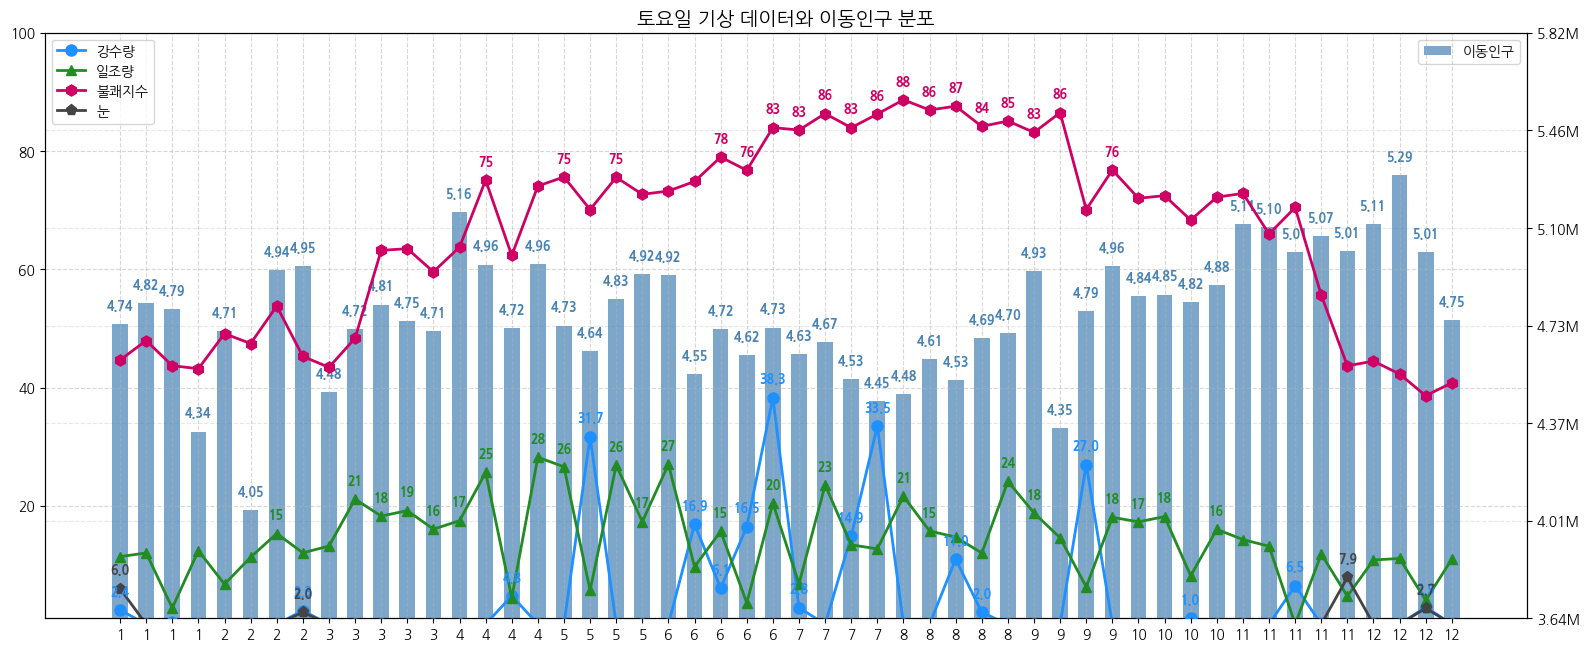

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import koreanize_matplotlib
import numpy as np

# 불쾌지수 계산 함수 추가
def calculate_discomfort_index(temp, humidity):
    """
    불쾌지수 계산: 1.8×기온–0.55×(1–습도)×(1.8×기온–26)+32
    temp: 기온(°C)
    humidity: 습도(0-100)
    """
    humidity = humidity / 100  # 백분율을 소수로 변환
    return 1.8 * temp - 0.55 * (1 - humidity) * (1.8 * temp - 26) + 32

# 결과 데이터프레임에 불쾌지수 컬럼 추가
result['불쾌지수'] = result.apply(lambda row: calculate_discomfort_index(row['최고온도'], row['습도']), axis=1)


# 전체 이동인구 기준으로 정렬
top_10 = result.sort_values('이동인구', ascending=False)


# 두 데이터프레임을 각각 날짜순으로 정렬
top_10 = top_10.sort_values('토요일')
bottom_10 = bottom_10.sort_values('토요일')

# 모든 이동인구 데이터를 합쳐서 전체 y축 범위 계산
all_pop_data = pd.concat([top_10['이동인구'], bottom_10['이동인구']])
global_min_pop = all_pop_data.min() * 0.9
global_max_pop = all_pop_data.max() * 1.1

# 두 개의 차트를 그리기 위한 함수
def create_weather_chart(df, title, subplot_pos):
    # X축에 사용할 인덱스 생성
    x_indices = np.arange(len(df))
    
    # 축 생성
    ax1 = plt.subplot(subplot_pos)
    ax2 = ax1.twinx()
    
    # 배경색 설정 (연한 회색)
    ax1.set_facecolor('#f5f5f5')
    
    # 격자 추가 - 격자는 가장 아래에 그림 (zorder=0)
    ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
    
    # 이동인구를 막대 그래프로 표시 (선 그래프 대신)
    bars = ax2.bar(x_indices, df['이동인구'], color='#4682B4', 
                alpha=0.7, width=0.6, label='이동인구', zorder=3)
    
    # 기상 데이터 선 그래프 그리기 (ax1에 그림, zorder=10)
    # 1. 강수량
    line1 = ax1.plot(x_indices, df['강수량'], 'o-', color='#1E90FF', linewidth=2, markersize=8, 
                    label='강수량', zorder=10)
    
    # 2. 일조량
    line2 = ax1.plot(x_indices, df['일조량'], '^-', color='#228B22', linewidth=2, markersize=7, 
                    label='일조량', zorder=10)
    
    # 3. 불쾌지수
    line3 = ax1.plot(x_indices, df['불쾌지수'], 'h-', color='#CF0063', linewidth=2, markersize=8, 
                    label='불쾌지수', zorder=10)
    
    # 4. 눈
    dark_gray = '#444444'
    line4 = ax1.plot(x_indices, df['눈'], 'p-', color=dark_gray, linewidth=2, markersize=8, 
                    label='눈', zorder=10)
    
    # 축의 zorder 설정
    ax1.set_zorder(6)  # 기상 데이터 축
    ax2.set_zorder(4)  # 이동인구 축
    
    # ax1의 배경이 ax2를 가리지 않도록 설정
    ax1.patch.set_visible(False)
    
    # y축 범위 설정 - 기상 데이터
    ax1.set_ylim(1, 100)
    
    # y축 범위 설정 - 이동인구 (전역 범위 사용)
    ax2.set_ylim(global_min_pop, global_max_pop)
    
    # 명시적인 틱 위치 설정 (이동인구 범위에 맞게 5~7개 정도의 눈금 설정)
    pop_range = global_max_pop - global_min_pop
    step = pop_range / 6  # 6개의 눈금으로 나누기
    tick_positions = np.arange(global_min_pop, global_max_pop + step, step)
    ax2.set_yticks(tick_positions)
    
    # 각 데이터 값 표시 - 텍스트는 최상위로 표시 (zorder=15)
    # 이동인구 값 표시 (막대 위에)
    for i, v in enumerate(df['이동인구']):
        # 이동인구 값을 막대 위에 표시 (백만 단위로 포맷팅)
        ax2.text(x_indices[i], v + (global_max_pop - global_min_pop) * 0.02, f"{v/1000000:.2f}", 
                ha='center', va='bottom', color='#4682B4', fontweight='bold', fontsize=9, 
                zorder=15)
    
    # 강수량 값 표시 (1mm 이상만)
    for i, v in enumerate(df['강수량']):
        if v >= 1:
            ax1.text(x_indices[i], v + 2, f"{v}", ha='center', va='bottom', 
                    color='#1E90FF', fontweight='bold', fontsize=9, zorder=15)
    
    # 일조량 값 표시 (높은 값만)
    for i, v in enumerate(df['일조량']):
        if v >= 15:
            ax1.text(x_indices[i], v + 2, f"{int(v)}", ha='center', va='bottom', 
                    color='#228B22', fontweight='bold', fontsize=9, zorder=15)
    
    # 불쾌지수 값 표시 (75 이상인 경우)
    for i, v in enumerate(df['불쾌지수']):
        if v >= 75:
            ax1.text(x_indices[i], v + 2, f"{int(v)}", ha='center', va='bottom', 
                    color='#CF0063', fontweight='bold', fontsize=9, zorder=15)
    
    # 눈 값 표시 (0보다 큰 경우만)
    for i, v in enumerate(df['눈']):
        if v > 0:
            ax1.text(x_indices[i], v + 2, f"{v}", ha='center', va='bottom', 
                    color=dark_gray, fontweight='bold', fontsize=9, zorder=15)
    
    # X축 설정 - 월.일 형식으로 표시
    dates = pd.to_datetime(df['토요일'])
    date_labels = []
    
    for date in dates:
        date_label = f"{date.month}"
        date_labels.append(date_label)
    
    plt.xticks(x_indices, date_labels, rotation=45, ha='right', fontsize=2)
    

    
    # 범례 추가
    if subplot_pos:
        # 기상 데이터 범례
        lines = line1 + line2 + line3 + line4
        labels = [l.get_label() for l in lines]
        legend1 = ax1.legend(lines, labels, loc='upper left', fontsize=10)
        legend1.set_zorder(20)

    # 이동인구 범례
    legend2 = ax2.legend(loc='upper right', fontsize=10)
    legend2.set_zorder(20)
    
    # 제목 추가
    plt.title(title, fontsize=14)
    
    # y축 틱 포맷 설정 (이동인구)
    import matplotlib.ticker as mticker
    
    # 포맷터 수정 - 백만 단위 표시를 명확하게
    def population_formatter(x, pos):
        return f'{x/1000000:.2f}M'
    
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(population_formatter))
    
    # 오른쪽 y축에도 그리드 추가
    ax2.grid(True, linestyle='--', alpha=0.3, axis='y', zorder=2)
    
    return ax1, ax2

# 전체 그림 설정
plt.figure(figsize=(16, 14))

# 상위 10개 차트 그리기
ax1_top, ax2_top = create_weather_chart(top_10, '토요일 기상 데이터와 이동인구 분포', 211)


# 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # 서브플롯 간 간격 조정

# 그래프 표시
plt.show()